In [22]:
import pandas as pd

# read the json file public_cases.json
# [
"""   {
    "input": {
      "trip_duration_days": 3,
      "miles_traveled": 93,
      "total_receipts_amount": 1.42
    },
    "expected_output": 364.51
  }, """

# load duration, miles, receipts, and output into a pandas dataframe
df = pd.read_json('public_cases.json')
df = pd.json_normalize(df['input'])

# Avoid division by zero for trips with 0 days, though unlikely in this dataset.
df['miles_per_day'] = df['miles_traveled'] / df['trip_duration_days'].replace(0, 1)
df['receipts_per_day'] = df['total_receipts_amount'] / df['trip_duration_days'].replace(0, 1)

# Feature for tiered mileage calculation
# Let's use the rates Lisa mentioned: $0.58 for the first 100 miles, and a lower rate after.
# We'll estimate the lower rate at $0.45 for this feature.
def calculate_tiered_mileage(miles):
    if miles > 100:
        return (100 * 0.58) + ((miles - 100) * 0.45)
    else:
        return miles * 0.58

df['tiered_mileage_feature'] = df['miles_traveled'].apply(calculate_tiered_mileage)

# Feature for Kevin's efficiency sweet spot
df['efficiency_bonus_flag'] = df['miles_per_day'].between(180, 220, inclusive='both').astype(int)

# Feature for the 5-day bonus
df['is_5_day_trip_flag'] = (df['trip_duration_days'] == 5).astype(int)

# Feature for the general 4-6 day sweet spot
df['is_sweet_spot_duration_flag'] = df['trip_duration_days'].between(4, 6, inclusive='both').astype(int)

# Feature for the low-receipt penalty (for amounts between $0 and $50)
df['low_receipt_penalty_flag'] = ((df['total_receipts_amount'] > 0) & (df['total_receipts_amount'] < 50)).astype(int)

# Feature for the cents bug
# We check if the cents part of the receipt amount is 49 or 99.
df['cents_bug_flag'] = df['total_receipts_amount'].apply(lambda x: round(x % 1, 2) in [0.49, 0.99]).astype(int)

# Feature for Kevin's "sweet spot combo"
# 5-day trips with 180+ miles/day and under $100/day in spending.
df['sweet_spot_combo_flag'] = ((df['trip_duration_days'] == 5) & 
                              (df['miles_per_day'] >= 180) & 
                              (df['receipts_per_day'] < 100)).astype(int)

# Feature for Kevin's "vacation penalty"
# 8+ day trips with high spending. Kevin suggests over $90/day for long trips.
df['vacation_penalty_flag'] = ((df['trip_duration_days'] >= 8) & 
                              (df['receipts_per_day'] > 90)).astype(int)

df['expected_output'] = pd.read_json('public_cases.json')['expected_output']


In [23]:
df.head()

,trip_duration_days,miles_traveled,total_receipts_amount,miles_per_day,receipts_per_day,tiered_mileage_feature,efficiency_bonus_flag,is_5_day_trip_flag,is_sweet_spot_duration_flag,low_receipt_penalty_flag,cents_bug_flag,sweet_spot_combo_flag,vacation_penalty_flag,expected_output
0,3,93.0,1.42,31.000000,0.473333,53.94,0,0,0,1,0,0,0,364.51
1,1,55.0,3.60,55.000000,3.600000,31.90,0,0,0,1,0,0,0,126.06
2,1,47.0,17.97,47.000000,17.970000,27.26,0,0,0,1,0,0,0,128.91
3,2,13.0,4.67,6.500000,2.335000,7.54,0,0,0,1,0,0,0,203.52
4,3,88.0,5.78,29.333333,1.926667,51.04,0,0,0,1,0,0,0,380.37


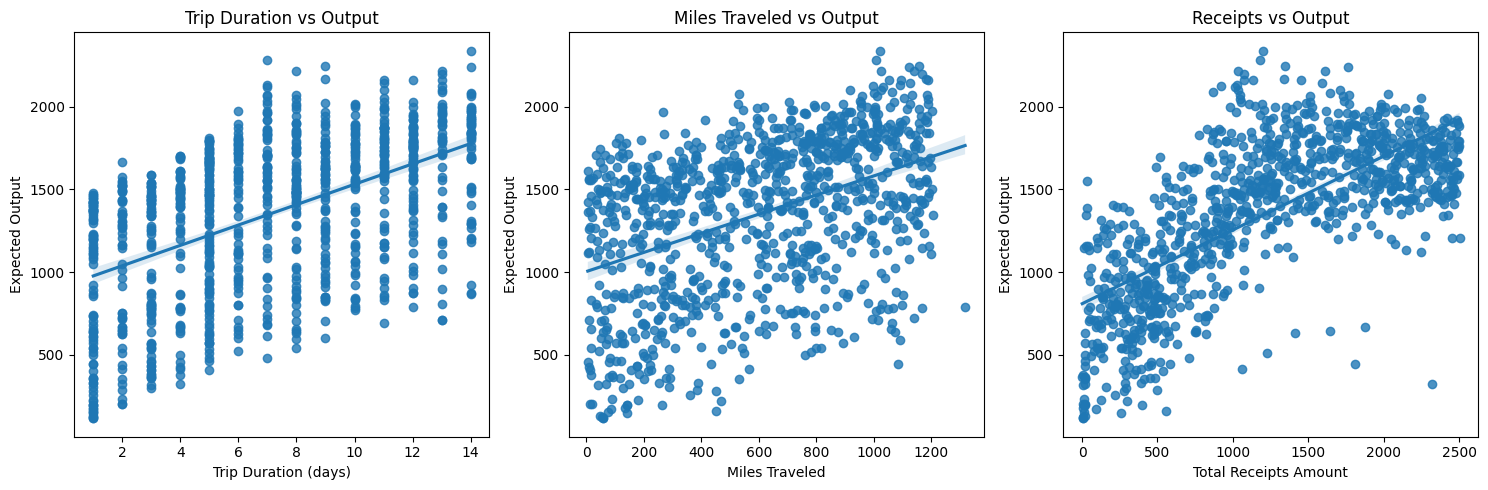

In [24]:
# plot duration vs output on a scatter plot and add a line of best fit
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot trip duration vs output
sns.regplot(data=df, x='trip_duration_days', y='expected_output', ax=ax1)
ax1.set_title('Trip Duration vs Output')
ax1.set_xlabel('Trip Duration (days)')
ax1.set_ylabel('Expected Output')

# Plot miles traveled vs output
sns.regplot(data=df, x='miles_traveled', y='expected_output', ax=ax2)
ax2.set_title('Miles Traveled vs Output')
ax2.set_xlabel('Miles Traveled')
ax2.set_ylabel('Expected Output')

# Plot receipts vs output
sns.regplot(data=df, x='total_receipts_amount', y='expected_output', ax=ax3)
ax3.set_title('Receipts vs Output')
ax3.set_xlabel('Total Receipts Amount')
ax3.set_ylabel('Expected Output')

plt.tight_layout()
plt.show()


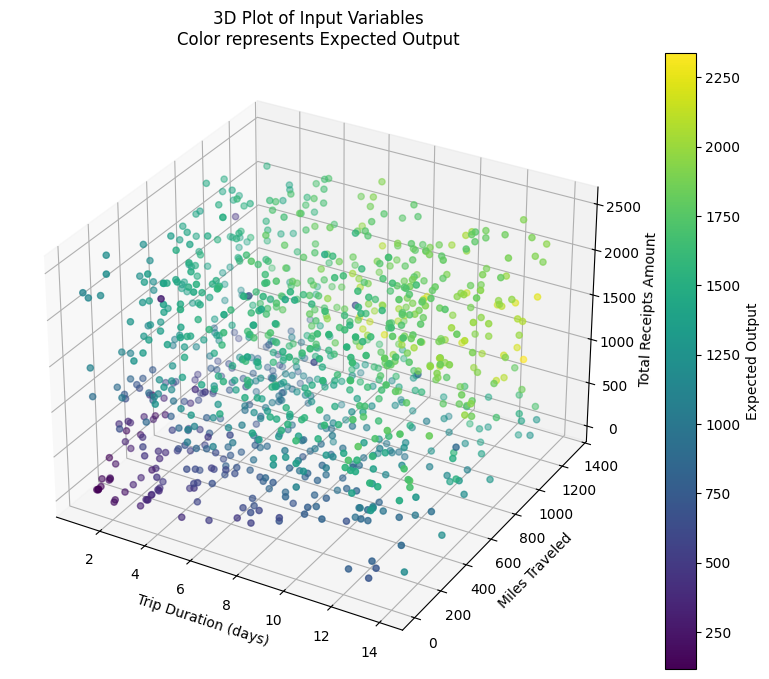

In [25]:
# make a 3d plot with color being the output
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
scatter = ax.scatter(df['trip_duration_days'], 
                    df['miles_traveled'], 
                    df['total_receipts_amount'],
                    c=df['expected_output'],
                    cmap='viridis')

# Add labels and title
ax.set_xlabel('Trip Duration (days)')
ax.set_ylabel('Miles Traveled')
ax.set_zlabel('Total Receipts Amount')
ax.set_title('3D Plot of Input Variables\nColor represents Expected Output')

# Add a colorbar
plt.colorbar(scatter, label='Expected Output')

plt.show()


In [26]:
%pip install plotly 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# make the 3d plot interactive
# Create an interactive 3D plot using plotly
import plotly.express as px

# Create the 3D scatter plot
fig = px.scatter_3d(df, 
                    x='trip_duration_days',
                    y='miles_traveled',
                    z='total_receipts_amount',
                    color='expected_output',
                    color_continuous_scale='viridis',
                    title='Interactive 3D Plot of Input Variables<br>Color represents Expected Output')

# Update layout
fig.update_layout(
    scene = dict(
        xaxis_title='Trip Duration (days)',
        yaxis_title='Miles Traveled',
        zaxis_title='Total Receipts Amount'
    ),
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()


# Analysis

In [48]:
from sklearn.model_selection import train_test_split

features_to_use = [
    'trip_duration_days', 'miles_traveled', 'total_receipts_amount',
    'miles_per_day', 'receipts_per_day', 'tiered_mileage_feature',
    'efficiency_bonus_flag', 'is_5_day_trip_flag', 'is_sweet_spot_duration_flag',
    'low_receipt_penalty_flag', 'cents_bug_flag', 'sweet_spot_combo_flag',
    'vacation_penalty_flag'
]
X = df[features_to_use]
y = df['expected_output']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = X, X, y, y # for testing
 

In [49]:
len(features_to_use)

13

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.2f}")


Linear Regression MSE: 37876.97


In [51]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

print(f"Tree MSE: {mean_squared_error(y_test, tree.predict(X_test)):.2f}")


Tree MSE: 15807.62


In [52]:
import numpy as np

import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

print(f"XGBoost MSE: {mean_squared_error(y_test, xgb_model.predict(X_test)):.2f}")


preds = xgb_model.predict(X_test).round()
match_rate = np.mean(preds == y_test)
print(f"Exact Match Rate: {match_rate*100:.2f}%")


XGBoost MSE: 1735.37
Exact Match Rate: 0.00%


In [53]:
import numpy as np
import pandas as pd

# Assume df, X, y, X_test, y_test, and xgb_model are already defined from your previous cells

# Get a random test case
random_idx = np.random.randint(0, len(X_test))
random_case = X_test.iloc[random_idx]
random_output = y_test.iloc[random_idx]

# Calculate Euclidean distance for all cases
distances = np.sqrt(
    ((X['trip_duration_days'] - random_case['trip_duration_days'])**2) +
    ((X['miles_traveled'] - random_case['miles_traveled'])**2) +
    ((X['total_receipts_amount'] - random_case['total_receipts_amount'])**2)
)

# Get indices of 5 closest cases
closest_indices = np.argsort(distances)[1:6]  # Skip first (self) and get next 5

# --- Print results with the corrected prediction call ---
print(f"Random case (Index: {random_case.name}):")
print(f"Trip Duration: {random_case['trip_duration_days']:.1f} days")
print(f"Miles Traveled: {random_case['miles_traveled']:.1f}")
print(f"Total Receipts: ${random_case['total_receipts_amount']:.2f}")
print(f"Expected Output: ${random_output:.2f}")

# --- FIX IS HERE ---
# Reshape the 1D Series to a 2D DataFrame for prediction
prediction_input = random_case.to_frame().T
print(f"XGBoost Prediction: ${xgb_model.predict(prediction_input).round(2)[0]:.2f}")
# --- END FIX ---

print("\n5 Closest Cases:")
print("-" * 50)

for idx in closest_indices:
    case = X.iloc[idx]
    output = df['expected_output'].iloc[idx]
    distance = distances[idx]
    print(f"Case Index: {case.name}")
    print(f"Trip Duration: {case['trip_duration_days']:.1f} days")
    print(f"Miles Traveled: {case['miles_traveled']:.1f}")
    print(f"Total Receipts: ${case['total_receipts_amount']:.2f}")
    print(f"Expected Output: ${output:.2f}")
    
    # --- FIX IS HERE ---
    # Also apply the fix inside the loop
    prediction_input_loop = case.to_frame().T
    print(f"XGBoost Prediction: ${xgb_model.predict(prediction_input_loop).round(2)[0]:.2f}")
    # --- END FIX ---

    print(f"Distance: {distance:.2f}")
    print("-" * 50)

Random case (Index: 424):
Trip Duration: 6.0 days
Miles Traveled: 425.0
Total Receipts: $709.75
Expected Output: $1114.90
XGBoost Prediction: $1042.30

5 Closest Cases:
--------------------------------------------------
Case Index: 820
Trip Duration: 9.0 days
Miles Traveled: 444.0
Total Receipts: $725.31
Expected Output: $1062.52
XGBoost Prediction: $1075.32
Distance: 24.74
--------------------------------------------------
Case Index: 631
Trip Duration: 11.0 days
Miles Traveled: 398.0
Total Receipts: $723.39
Expected Output: $1154.77


XGBoost Prediction: $1120.99
Distance: 30.66
--------------------------------------------------
Case Index: 269
Trip Duration: 11.0 days
Miles Traveled: 448.0
Total Receipts: $732.79
Expected Output: $1090.35
XGBoost Prediction: $1120.47
Distance: 32.94
--------------------------------------------------
Case Index: 30
Trip Duration: 5.0 days
Miles Traveled: 477.0
Total Receipts: $704.42
Expected Output: $1045.96
XGBoost Prediction: $1063.78
Distance: 52.28
--------------------------------------------------
Case Index: 671
Trip Duration: 8.0 days
Miles Traveled: 392.0
Total Receipts: $661.27
Expected Output: $978.13
XGBoost Prediction: $975.33
Distance: 58.68
--------------------------------------------------


In [54]:
X = df[features_to_use]
df['predicted_output'] = xgb_model.predict(X)

# Calculate the error (also called the residual)
# A positive error means the prediction was lower than the actual output.
# A negative error means the prediction was higher than the actual output.
df['prediction_error'] = df['expected_output'] - df['predicted_output']

# Label each row as belonging to the 'Train' or 'Test' set for better visualization
df['Set'] = 'Train'
df.loc[X_test.index, 'Set'] = 'Test'


# --- Step 2: Create the Interactive 3D Plot ---

print("Generating interactive plot... The color represents prediction error.")
print("Blue points: Model predicted HIGHER than actual (error < 0)")
print("Red points: Model predicted LOWER than actual (error > 0)")


# Create the 3D scatter plot using plotly
fig = px.scatter_3d(
    df,
    x='trip_duration_days',
    y='miles_traveled',
    z='total_receipts_amount',
    color='prediction_error',
    symbol='Set',  # Use different shapes for Train vs. Test data
    color_continuous_scale=px.colors.diverging.RdBu,  # Red-Blue scale is great for errors
    color_continuous_midpoint=0,  # Center the color scale at zero error
    title='Interactive 3D Plot of XGBoost Prediction Errors',
    # Add custom data to see on hover for detailed analysis
    hover_data={
        'expected_output': ':.2f',
        'predicted_output': ':.2f',
        'prediction_error': ':.2f'
    }
)

# --- Step 3: Update Layout and Display ---

# Update layout for clarity
fig.update_layout(
    scene=dict(
        xaxis_title='Trip Duration (days)',
        yaxis_title='Miles Traveled',
        zaxis_title='Total Receipts Amount'
    ),
    legend_title_text='Data Set',
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()


Generating interactive plot... The color represents prediction error.
Blue points: Model predicted HIGHER than actual (error < 0)
Red points: Model predicted LOWER than actual (error > 0)


In [55]:
# save the xgb model to a file
import joblib

# Save the XGBoost model to a file
joblib.dump(xgb_model, 'xgb_model.joblib')

print("Model saved successfully to 'xgb_model.joblib'")


Model saved successfully to 'xgb_model.joblib'


In [ ]:
# load the xgb model from a file
# and predict the output for the given input
# echo "Input: $1 days, $2 miles, \$$3 receipts"
# python calculate_reimbursement.py "$1" "$2" "$3"